In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from libs.losses import  l2
from libs.metric import SignalDice as sdsc

In [2]:
def mse(a, b):
    return np.mean((a-b)**2)

def mae(a, b):
    return np.mean(np.abs(a-b))

def dtw_distance_normalized(s1, s2):
    n, m = len(s1), len(s2)
    dtw_matrix = np.full((n + 1, m + 1), np.inf)
    dtw_matrix[0, 0] = 0

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = abs(s1[i - 1] - s2[j - 1])
            dtw_matrix[i, j] = cost + min(
                dtw_matrix[i - 1, j],    # insertion
                dtw_matrix[i, j - 1],    # deletion
                dtw_matrix[i - 1, j - 1] # match
            )

    # Traceback to count the path length
    i, j = n, m
    path_length = 0
    while i > 0 and j > 0:
        path_length += 1
        min_idx = np.argmin([
            dtw_matrix[i-1, j-1],
            dtw_matrix[i-1, j],
            dtw_matrix[i, j-1]
        ])
        if min_idx == 0:
            i -= 1
            j -= 1
        elif min_idx == 1:
            i -= 1
        else:
            j -= 1
    path_length += (i + j)  # finish remaining steps

    return dtw_matrix[n, m] / path_length
    
def make_signals(sampling_rate, noise_level=0.3, shift=0.5, scale_factor=0.5):
    t = np.linspace(0,2*np.pi, sampling_rate) 
    gt = np.sin(t)#* 0.2
    signals = {
        "t" : t,
        "gt" : gt,
        "inverted": -gt,
        "scaled" :scale_factor * gt,
        "scaled2":scale_factor * gt*2,
        "scaled3":scale_factor * gt*4,
        "shift"  :np.sin(t)+shift,
        "shift2" :np.sin(t)-shift,
        "shift3" :np.sin(t)+shift+shift,
        "noisy":gt + noise_level * np.random.randn(sampling_rate),
        "hybrid": 0.8*np.sin(t+shift) #* 0.2
    }
    return signals


def make_peak_signals(sampling_rate, noise_level=0.3, shift=0.5, scale_factor=0.5):
    gt = np.ones(sampling_rate) 
    gt[int(sampling_rate//2)] = 10
    signals = {
        "gt" : gt,
        "line":np.ones(sampling_rate)*2,        
        "line2":np.ones(sampling_rate)/2,
    }
    return signals

In [3]:
sampling_rate = 1000
sdsc   = sdsc(eps=0)
signal = make_signals(sampling_rate)
peak_singal = make_peak_signals(sampling_rate)

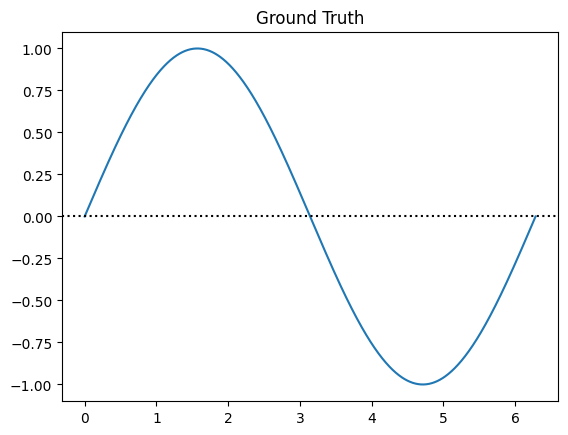

In [4]:
plt.figure()
plt.plot(signal['t'], signal['gt'])
plt.axhline(0, c="k", ls=":")
plt.title("Ground Truth")
plt.show()

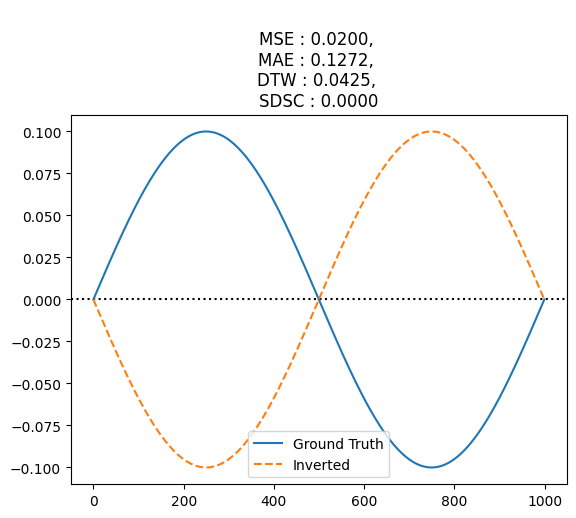

In [11]:
gt = signal['gt'] * 0.1
test = signal['inverted'] * 0.1
mse_result  = mse(gt, test)
mae_result  = mae(gt, test)
dtw_result  = dtw_distance_normalized(gt, test)
sdsc_result = sdsc(torch.tensor(gt, dtype=torch.float32), torch.tensor(test, dtype=torch.float32)).item()
plt.figure()
plt.axhline(0, c="k", ls=":")
plt.plot(gt, label="Ground Truth")
plt.plot(test, "--", label="Inverted")
plt.legend()
strings = f"""
MSE : {mse_result:.4f}, 
MAE : {mae_result:.4f}, 
DTW : {dtw_result:.4f}, 
SDSC : {sdsc_result:.4f}"""
plt.title(strings)
plt.show()

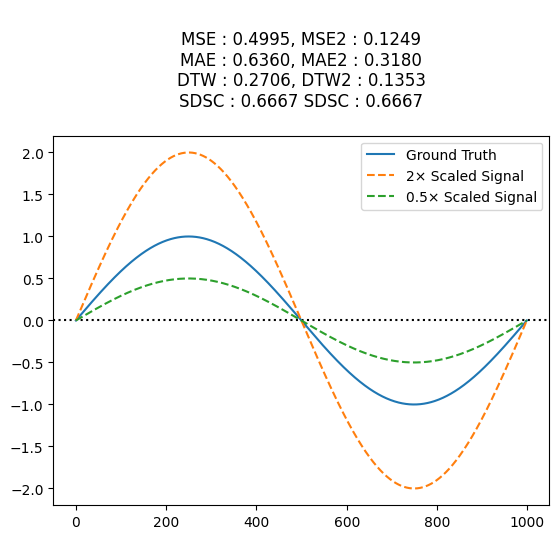

In [6]:
gt = signal['gt'] 
test1 = signal['gt'] * 2
test2 = signal['gt'] / 2
mse_result = mse( gt, test1)
mse_result2 = mse( gt, test2)
mae_result = mae( gt, test1)
mae_result2 = mae( gt, test2)
dtw_result  = dtw_distance_normalized(gt, test1)
dtw_result2  = dtw_distance_normalized(gt, test2)
sdsc_result = sdsc(torch.tensor(gt, dtype=torch.float32), torch.tensor(test1, dtype=torch.float32)).item()
sdsc_result2 = sdsc(torch.tensor(gt, dtype=torch.float32), torch.tensor(test2, dtype=torch.float32)).item()
plt.figure()
plt.axhline(0, c="k", ls=":")
plt.plot(gt, label="Ground Truth")
plt.plot(test1,  "--", label="2× Scaled Signal")
plt.plot(test2,  "--", label="0.5× Scaled Signal")
plt.legend()
strings  = f"""
MSE : {mse_result:.4f}, MSE2 : {mse_result2:.4f}
MAE : {mae_result:.4f}, MAE2 : {mae_result2:.4f}
DTW : {dtw_result:.4f}, DTW2 : {dtw_result2:.4f}
SDSC : {sdsc_result:.4f} SDSC : {sdsc_result2:.4f}
"""
plt.title(strings)
plt.show()

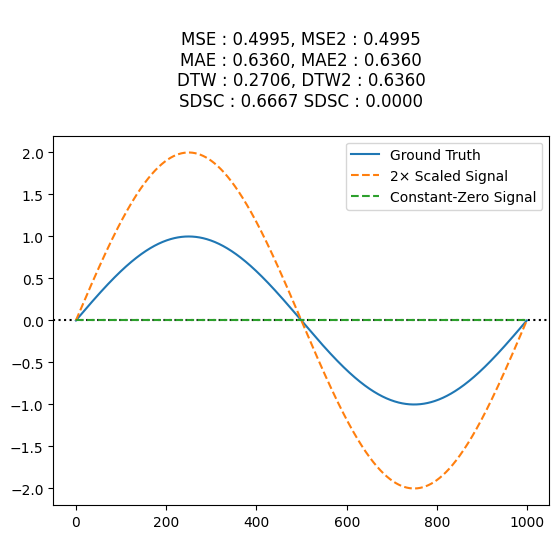

In [13]:
gt = signal['gt'] 
test1 = signal['gt'] * 2
test2 = signal['gt'] * - 0.
mse_result = mse( gt, test1)
mse_result2 = mse( gt, test2)
mae_result = mae( gt, test1)
mae_result2 = mae( gt, test2)
dtw_result  = dtw_distance_normalized(gt, test1)
dtw_result2  = dtw_distance_normalized(gt, test2)
sdsc_result = sdsc(torch.tensor(gt, dtype=torch.float32), torch.tensor(test1, dtype=torch.float32)).item()
sdsc_result2 = sdsc(torch.tensor(gt, dtype=torch.float32), torch.tensor(test2, dtype=torch.float32)).item()
plt.figure()

plt.axhline(0, c="k", ls=":")
plt.plot(gt, label="Ground Truth")
plt.plot(test1, "--", label="2× Scaled Signal")
plt.plot(test2,  "--", label="Constant-Zero Signal")
plt.legend()
strings  = f"""
MSE : {mse_result:.4f}, MSE2 : {mse_result2:.4f}
MAE : {mae_result:.4f}, MAE2 : {mae_result2:.4f}
DTW : {dtw_result:.4f}, DTW2 : {dtw_result2:.4f}
SDSC : {sdsc_result:.4f} SDSC : {sdsc_result2:.4f}
"""
plt.title(strings)
plt.show()

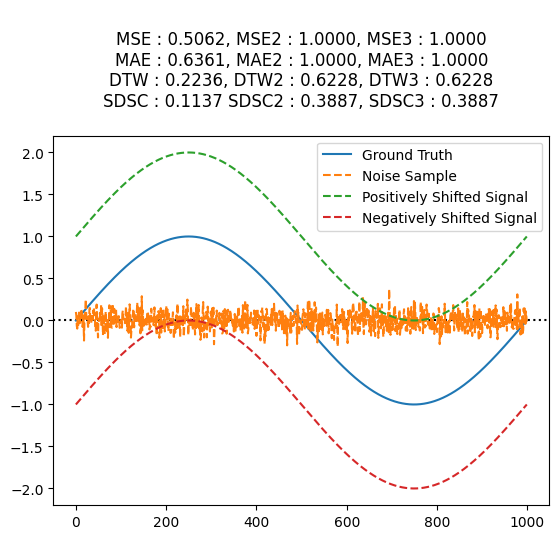

In [8]:
gt = signal['gt'] 
test1 = np.zeros(sampling_rate) + (np.random.randn(sampling_rate) * 0.1)
test2 = signal['gt'] + 1
test3 = signal['gt'] - 1
mse_result   = mse( gt, test1)
mse_result2  = mse( gt, test2)
mse_result3  = mse( gt, test3)
mae_result   = mae( gt, test1)
mae_result2  = mae( gt, test2)
mae_result3  = mae( gt, test3)
dtw_result   = dtw_distance_normalized(gt, test1)
dtw_result2  = dtw_distance_normalized(gt, test2)
dtw_result3  = dtw_distance_normalized(gt, test3)
sdsc_result  = sdsc(torch.tensor(gt, dtype=torch.float32), torch.tensor(test1, dtype=torch.float32)).item()
sdsc_result2 = sdsc(torch.tensor(gt, dtype=torch.float32), torch.tensor(test2, dtype=torch.float32)).item()
sdsc_result3 = sdsc(torch.tensor(gt, dtype=torch.float32), torch.tensor(test3, dtype=torch.float32)).item()
plt.figure()
plt.axhline(0, c="k", ls=":")
plt.plot(gt, label="Ground Truth")
plt.plot(test1,  "--",label="Noise Sample")
plt.plot(test2,  "--",label="Positively Shifted Signal")
plt.plot(test3,  "--",label="Negatively Shifted Signal")
plt.legend()
strings  = f"""
MSE : {mse_result:.4f}, MSE2 : {mse_result2:.4f}, MSE3 : {mse_result3:.4f}
MAE : {mae_result:.4f}, MAE2 : {mae_result2:.4f}, MAE3 : {mae_result3:.4f}
DTW : {dtw_result:.4f}, DTW2 : {dtw_result2:.4f}, DTW3 : {dtw_result3:.4f}
SDSC : {sdsc_result:.4f} SDSC2 : {sdsc_result2:.4f}, SDSC3 : {sdsc_result3:.4f}
"""
plt.title(strings)
plt.show()